```
conda install -y h5py seaborn scikit-learn
pip install tensorflow 
git clone git@github.com:fchollet/keras.git && cd keras && python setup.py install
```

## Uczenie głębokie z wykorzystaniem dedykowanych narzędzi

### Spis treści:
    1) Wstęp: oprogramowanie dedykowane sieciom neuronowym
    2) Wstep do obliczeń symbolicznych
        2.0) teoria
        2.1) ćwiczenie
    3) Keras
        3.0) prezentacja framework'u
        3.1) ćwiczenie: implementacja modelu
        3.2) implementacja warstw
        3.3) ćwiczenie: implementacja własnej warstwy
    4.) Hands-on computer vision: prezentacja i ćwiczenie z rozponawania obrazu

----

## 1.)  Wstęp: oprogramowanie dedykowane sieciom neuronowym

- Wraz z rosnącym zainteresowaniem sieciami neuronowymi, rosło zapotrzebowanie na dedykowane narzędzia, które ułatwiłyby i przyspieszyły proces tworzenia, a następnie uczenia głębokich modeli. 


- Z upływem lat kolejne grupy badawcze prezentowały swoje rozwiązania, a w ostatnim czasie tematem zainteresował się również przemysł. Dzięki nowym źródłom finansowania i niesłabnącemu zapotrzebowaniu, większość frameworków jest obecnie aktywnie rozwijana i ulepszana.

- Do najpopularniejszych narzędzi należą:

    - [Tensorflow](http://tensorflow.org) (**Google**)
        - Python, Go, C++
        - Najpopularniejszy z obecnie istniejących frameworków
        - Najintensywniej rozwijany

    - [Theano](http://deeplearning.net/software/theano/) (**U. Montreal**)
        - Python
        - Był prekursorem TensorFlow
        - Rozwijany przez uniwersytet w Montrealu (non-profit)
        - Obecnie coraz częściej porzucany na rzecz TF

    - [Torch](http://torch.ch/) (**Facebook, Twitter**)
        - Lua
        - Najmniej popularny ze względu na brak bindingów Pythonoych
        - Nie wspiera automatycznego różniczkowania

    - [MXNet](http://mxnet.io/) (**Amazon**)
        - Python, C++, Go, Julia, Scala, R, ...
        - Najwydajniejszy pod względem pamięci 
        - Od niedawna wspierany przez Amazon

<img style="float: left;" src="img/tf-logo-2.png"> 
<img style="float: left;" src="img/th-logo.png">
<img style="float: left;" src="img/torch-logo-f.png">
<img style="float: left;" src="img/mx-logo.png">

- Wszystkie z tych narzędzi są rozwijane jako proejkty OpenSource:

    - https://github.com/tensorflow/tensorflow

    - https://github.com/torch/torch7

    - https://github.com/Theano/Theano

    - https://github.com/dmlc/mxnet

- Wymienione wyżej narzędzia to zazwyczaj biblioteki operujące na dosyć niskim poziomie abstrakcji.

- Wokół nich powstało wiele projektów mających jeszcze bardziej ułatwić użytkownikom uczenie sieci neuronowych.

- Najpopularniejszym z takich projektów jest obecnie **Keras**, na którym skupimy się w dalszej części

![k](img/keras-logo.png)

----

## 2.) Wstep do obliczeń symbolicznych

- Sercem większości frameworków wysokiego poziomu jest jeden z wyżej wymienionych silników.
- Keras, którego będziemy dzisiaj używać, posiada dwa takie backendy: Tensorflow oraz Theano
- Warto poświęcić chwilę, żeby zapoznać się z najbardziej podstawowymi zastadami ich działania.

- Tensorflow i Theano to przykłady narzędzi, które tworzą graf operacji symbolicznych.

- Oznacza to, że operacje wykonywane na zmiennych nie mają natychmiastowego efektu. Są jedynie dodawane do grafu.

- Następnie graf jest kompilowany i wykonwyany.

Przykład:

In [3]:
import tensorflow as tf
import numpy as np

from helpers3 import show_graph
from helpers3 import execute_tf_graph

def get_tf_graph():
    return tf.get_default_graph().as_graph_def()

In [4]:
tf.reset_default_graph()

a = tf.Variable(2.)
b = tf.Variable(2.)
result = a + b

print(result)

Tensor("add:0", shape=(), dtype=float32)


`result` nie jest równe 4! 

Jest tylko węzłem w grafie, symbolizującym operację dodania zmiennej `a` do `b`

In [5]:
graph = get_tf_graph()

show_graph(graph_def=graph, width=900, height=300)

Zbudowany graf możemy "wykonać", jako parametr `outptus` podając te zmienne, które chcemy obliczyć.

In [6]:
execute_tf_graph(result)

[4.0]

Dobrze, ale co zrobić, jeżeli chcemy obliczyć sumę `2 + 3`. Czy musimy zbudować i skompilować cały graf od nowa?

Na szczęście nie -- możemy podać wartości dowolnej zmiennej w grafie przy jego wywołaniu.

Aby to zrobić, tworzymy słownik, który przypisze wybranym zmiennym odpowiednie wartości

In [7]:
inputs = {
    a: 2,
    b: 3
}

execute_tf_graph(outputs=result, inputs=inputs)

[5.0]

Zwróć uwagę, że w słowniku tym nie podajemy nazw zmiennych (typu `str`), ale obiekty `Pythona`!

**Uwaga!**: w praktyce, jeżeli chcemy, żeby nasza zmienna była inicjalizowana dopiero przy wywołaniu grafu, 
oraz żeby jej podanie było obowiązkowe, należy **tf.Variable** zamienić na **tf.placeholder**

In [8]:
tf.reset_default_graph()
a = tf.placeholder(dtype=np.float32, name='zmienna_a')
result = a + 1

try:
    execute_tf_graph(result)
except tf.python.errors.InvalidArgumentError as e:
    print(e.message)

You must feed a value for placeholder tensor 'zmienna_a' with dtype float
	 [[Node: zmienna_a = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: add/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_8_add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


----

### zadanie 1: 
    - oblicz kwadraty liczb 2, 3 i 4 używając tensorflow. Wykorzystaj mechanizm placeholderów

### rozwiązanie 1: 

In [9]:
x = tf.placeholder(np.float32)
result = x * x

for i in {2, 3, 4}:
    outputs = result
    inputs = {
        x: i
    }
    
    returned = execute_tf_graph(outputs=result, inputs=inputs)
    print(returned)

[4.0]
[9.0]
[16.0]


### zadanie 2: 
    - dodaj dwie macierze jednostkowe 2x2

### rozwiązanie 2: 

In [10]:
A = tf.placeholder(dtype=np.float32)
B = tf.placeholder(dtype=np.float32)
result = A + B

inputs = {
    A: np.array([
            [1, 0],
            [0, 1]
        ]),
    B: np.array([
            [1, 0],
            [0, 1]
        ])
}

execute_tf_graph(outputs=[result], inputs=inputs)

[array([[ 2.,  0.],
        [ 0.,  2.]], dtype=float32)]

- Warto zaznaczyć, iż **Tensorflow został stworzony dla operacji na macierzach (tensorach)**. Radzi więc sobie wspaniale z wielowymiarowymi danymi. (Patrz rozw. powyżej)

- Jakie są jednak konkretne zalety tego symbolicznego podejścia? Trzy najważniejsze to:
    1. Optymalizacja: znając cały graf, kompilator może zoptymalizować wykonywane operacje
    2. Współbieżność: kompilator sam zadba o to, aby wykonać obliczenia równolegle
    3. Niezależność od architektury: Znając graf, kompilator może wygenerować kod dla CPU / GPU / FPGA etc.
    
- Szczególnie punkt trzeci jest tak istotny, gdyż obecnie do uczenia sieci neuronowych niemalże niezbędny jest procesor graficzny wspierający technologię `CUDA`

---- 

## 3.) Keras

### Czym is Keras?

Za https://keras.io:

> ### Keras: Deep Learning library for Theano and TensorFlow
>
> Keras is a **high-level neural networks** library, written in **Python** and capable of running on top of either **TensorFlow** or **Theano**. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

- Jest to biblioteka mająca ułatwić tworzenie sieci neuronowych, operująca na wyższym poziomie abstrakcji niż tensorflow / theano
- Jako backendu obliczeniowego może wykorzystywać jeden z wyżej wymienionych silników


### Dlaczego Keras?

- Łatwy do opanowania
- Czytelny
- Popularny i aktywnie rozwijany 
- Dobrze udokumentowany

### Jak nauczyć sieć neuronową?

Będziemy potrzebować trzech elementów:
1. Dane
2. Architektura sieci
3. Metoda optymalizacji
    - Funkcja straty
    - Algorytm optymalizacyjny

#### Dane

- Keras współpracuje z numpy, w związku z tym można korzystać z dowolnego zbioru danych, który jesteśmy w stanie wczytać do pamięci.
- Może korzystać ze zbiorów zbyt dużych, żeby zmieśćić się w pamięci: potrzebna jest wtedy biblioteka `h5py`
- Posiada także kilka wbudowanych zbiorów danych, jak np. mnist

#### [MNIST](http://yann.lecun.com/exdb/mnist/)
- klasyczny benchmark w computer vision (ponad 700 cytowań w pracach naukowych)
- 60 000 obrazów przedstawiających cyfry napisane ludzką ręką
- Można załadować bezpośrednio z kerasa

![mnist](img/mnist.png)

In [11]:
%matplotlib inline

from keras.datasets import mnist
from keras.utils import np_utils

import seaborn as sns

(X_train, y_train), (X_test, y_test) = mnist.load_data()
img_size = 28

print("Wymiary zbioru, X: {}, y: {}".format(X_train.shape, y_train.shape))

Using TensorFlow backend.


Wymiary zbioru, X: (60000, 28, 28), y: (60000,)


Przygotowanie danych: 
    - Obrazy, które trafiają do sieci neuronowej muszą mieć odpowiedni "kształt" (shape) oraz typ: 
        - (liczba_przykładóœ, szerokość, wysokość, liczba-kanałóœ) 
        - typem danych powinien być float32, a elementy macierzy powinny być w zakresie [0., 1.]
    - Etykiety (informacja, którą cyfrę przedstawia dany obrazek), powinny mieć kształt (liczba_przykładów, liczba_cyfr) patrz poniżej

In [12]:
# Keras oczekuje, iż etykiety będą macierzą binarną o kształcie (liczba_przykładów, liczba_możliwych_etykiet)
# Mówimy, że dany obraz należy do klasy **i**, kiedy w kolumnie **i-tej** znajduje się 1
# przykład:
etykiety = [
    0,
    1,
    2
]

etykiety_keras = [
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0]
]

# aby zamienić etykiety wczytane przez mnist.load_data(), skorzystamy z funkcji pomocniczej kerasa "to_categorical":
Y_train = np_utils.to_categorical(y_train, 10)
Y_test  = np_utils.to_categorical(y_test,  10)

In [13]:
# Przygotujmy też same obrazki
rozmiar = 28
X_train = X_train.reshape(-1, rozmiar, rozmiar, 1)
X_test  = X_test.reshape(-1,  rozmiar, rozmiar, 1)

X_train = X_train.astype(np.float32) / 255.
X_test  = X_test.astype(np.float32) / 255.

Label:  2


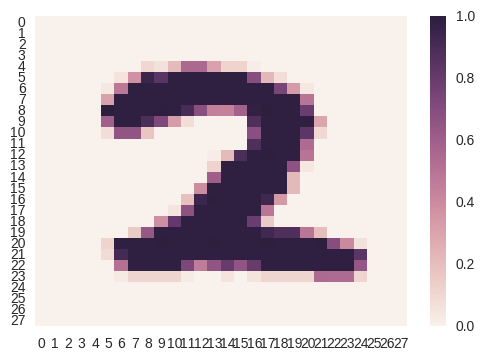

In [14]:
# Sprawdzźmy, jak wyglądają nasze dane:
i = np.random.randint(0, y_train.shape[0])

print("Label: ", y_train[i])
sns.heatmap(X_train[i].reshape(rozmiar, rozmiar));

#### Architektura sieci
- Keras wspiera dwie metody definiowania architektury: model liniowy i API funkcjonalne.
- Skupimy się dzisiaj głównie na modelach liniowych, ponieważ w zupełności wystarczają one do większośći zastosowań praktycznych.
- Kluczowym pojęciem przy definiowaniu architektury jest pojęcie **warstwy**

#### Warstwy:

- Podstawowym elementem, z którego budowana jest sieć neuronowa, jest warstwa. 
- Model liniowy w kerasie to nic innego, jak tylko złożenie kolejnych, następujących po sobie warstw.
- Warstwa (layer) jest podstawową jednostką przetwarzania: 
- przyjmuje ona jakąś macierz (tensor) na wejściu, modyfikuje ją, a następnie podaje na wyściu

In [19]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Input

from helpers3 import plot_confusion_matrix

In [16]:
# Aby zobrazować to w praktyce, zaimplementujemy regresję logistyczną, poznaną na poprzednich zajęciach, z użyciem kerasa

# zdefiniujmy sobie najpierw warstwy, których użyjemy:

# regresja logistyczna oczekuje jednowymiarowego wektora cech. Obrazki to macierze kwadratowe, należy je "słaszczyć"
flatten_layer = Flatten(input_shape=(rozmiar, rozmiar, 1))

# następnie wektor cech jest mnożony przez macierz wag. Macierz wag ma rozmiar (liczba_cech x liczba_klas)
# Keras sam odgadnie, jaka jest liczba cech! Podajemy jedynie liczbę klas.
# Warstwą realizującą mnożenie macierzy jest warstwa Dense:
matmul_layer = Dense(10)

# Teraz nasz model pobiera na wejściu obrazek 20x20, a generuje wektor o rozmiarze (10, ), 
# gdzie każdy element tego wektora to "wynik" danej klasy. Należy zamienić jeszcze ten wynik na prawdopodobieństwa
get_probas_layer = Activation("softmax")

# I to wszystko! Zbudujmy model ze zdefiniowanych wyżej warstw
model = Sequential()
model.add(flatten_layer)
model.add(matmul_layer)
model.add(get_probas_layer)

#### Metoda optymalizacji
- Keras musi wiedzieć, jaką funkcję straty chcemy minimalizować.
- Musi także wiedzieć, jakiej metody ma użyć do minimalizacji
- Dobra wiadomość: nie musimy umieć implementować tych elementów: keras o wszystko zadba!

skorzystamy ze standardowego zestawu w przypadku klasyfikacji: straty logistycznej i optymalizatora [Adam](google.com)

In [17]:
f_straty = "categorical_crossentropy"
optymalizator = "adam"

# Model należy jeszcze skompilować, podając wybraną stratę i optymalizator
model.compile(loss=f_straty, optimizer=optymalizator)

#### Uczenie:
- Nasz model jest już kompletny!
- Teraz wystarczy wywołać funkcję, która rozpocznie proces uczenia

In [18]:
liczba_iteracji = 5
model.fit(X_train, Y_train, nb_epoch=liczba_iteracji)

Epoch 1/5
60000/60000 [==============================] - 4s - loss: 0.4731     
Epoch 2/5
60000/60000 [==============================] - 4s - loss: 0.3041     
Epoch 3/5
60000/60000 [==============================] - 3s - loss: 0.2830     
Epoch 4/5
60000/60000 [==============================] - 4s - loss: 0.2732     
Epoch 5/5
60000/60000 [==============================] - 4s - loss: 0.2665     


 9696/10000 [============================>.] - ETA: 0s
Accuracy: 0.9266


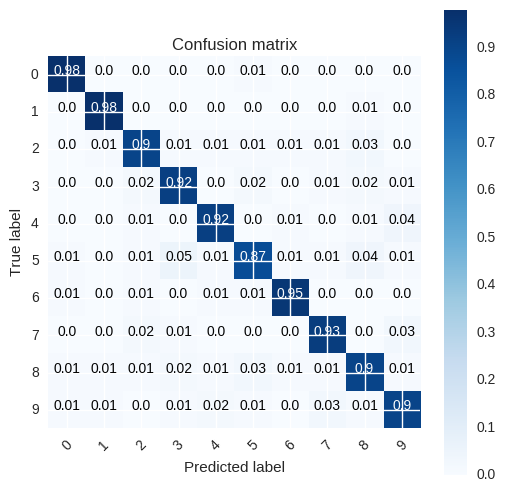

In [22]:
# jak sobie poradziliśmy?
preds = model.predict_classes(X_test)
acc   = np.mean(preds == y_test)

plot_confusion_matrix(y_test, preds)
print("\nAccuracy: {}".format(acc))

#### Gdzie są sieci neuronowe?!

- Powyższy model to zwykła regresja logistyczna w kerasie. Jak przejść od niej do uczenia głębokiego? 
- Proste: dodać więcej warstw!

In [34]:
model = Sequential()

model.add(Flatten(input_shape=(rozmiar, rozmiar, 1)))

# pomiędzy warstwami mnożącymi macierze powinny znajdować się funkcje aktywacji
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.15)) # todo?

model.add(Dense(32))
model.add(Activation("relu")) 
model.add(Dropout(0.15)) 

model.add(Dense(10))
model.add(Activation("softmax")) 

model.compile('adam', 'categorical_crossentropy')

In [35]:
liczba_iteracji = 5
model.fit(X_train, Y_train, nb_epoch=liczba_iteracji)

Epoch 1/5
60000/60000 [==============================] - 5s - loss: 0.5259     
Epoch 2/5
60000/60000 [==============================] - 5s - loss: 0.3001     
Epoch 3/5
60000/60000 [==============================] - 5s - loss: 0.2503     
Epoch 4/5
60000/60000 [==============================] - 5s - loss: 0.2277     
Epoch 5/5
60000/60000 [==============================] - 5s - loss: 0.2074     


In [36]:
# jak sobie poradziliśmy?
preds = model.predict_classes(X_test)
acc   = np.mean(preds == y_test)

print("\nAccuracy: {}".format(acc))

 9760/10000 [============================>.] - ETA: 0s
Accuracy: 0.9589


#### Sieci konwolucyjne
- Dotychczas jako podstawowych elementów przetwarzania używaliśmy warstw, które wykonują proste mnożenie macierzy
- Istnieją warstwy, które dedykowane są konkretnie rozpoznawaniu obrazów: tzw. warstwy konwolucyjne.
- Dobieranie parametrów tych warstw to bardziej sztuka niż nauka i wymaga sporej wprawy. Dlatego nie zjamiemy się tym na tych zajęciach.

In [38]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [45]:
# Przykład sieci z warstwami konwolucyjnymi
model = Sequential()

model.add(Convolution2D(8, 3, 3, border_mode='valid', input_shape=(rozmiar, rozmiar, 1)))
model.add(Activation('relu'))

model.add(Convolution2D(8, 3, 3))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile('adam', 'categorical_crossentropy')

In [46]:
liczba_iteracji = 5
model.fit(X_train, Y_train, nb_epoch=liczba_iteracji)

Epoch 1/5
60000/60000 [==============================] - 6s - loss: 0.2067     
Epoch 2/5
60000/60000 [==============================] - 6s - loss: 0.0802     
Epoch 3/5
60000/60000 [==============================] - 6s - loss: 0.0587     
Epoch 4/5
60000/60000 [==============================] - 6s - loss: 0.0455     
Epoch 5/5
60000/60000 [==============================] - 6s - loss: 0.0376     


In [48]:
# jak sobie poradziliśmy?
preds = model.predict_classes(X_test)
acc   = np.mean(preds == y_test)

print("\nAccuracy: {}".format(acc))

 9952/10000 [============================>.] - ETA: 0s
Accuracy: 0.9856


#### "Prawdziwa" sieć neuronowa
- Keras udostępnia gotowe, wyuczone już modele.
- Są to potężne sieci neuronowe, uczone tygodniami na olbrzymim zbiorze danych [Imagenet](google.com)
- Możemy wykorzystać tę sieć i szybko dostosować ją do własnych potrzeb

- Spróbujemy w krótkim czasie stworzyć model, który z dużą dokładnością (ok. 90%) nauczy się odróżniać koty od psów
- W tym celu potrzebne nam będą dwa dodatkowe pojęcia: `data augmentation` oraz `bottleneck features`

#### Data augmentation
- Jest to proces sztucznego "powiększania" zbioru dostępnych danych. 
- Powiedzmy, że mamy do dyspozycji 1000 zdjęć kotów. Aby nauczyć sieć neuronową, możemy ręcznie wygenerować na ich podstawie "sztuczne" dane: każdy z obrazków będziemy losowo obracać, skalować i rozciągać. W ten sposób dostarczymy więcej różnych zdjęć, nie ponosząc jednak kosztów fotografowania tysięcy kotów
- Keras dostarcza gotową funkcję, `ImageDataGenerator`, która zajmie się tą transformacją za nas.

#### Bottleneck features
- Wiemy, że sieć neuronowa posiada warstwy
- Wiemy, że warstwy pobierają pewne dane, dokonują ich transformacji, i przekazują dalej. 
- Okazuje się, iż każda taka warstwa uczy się rozpoznawać pewną klasę obiektów, a im głębiej w sieć, tym bardziej abstrakcyjne są owe klasy.
- Przykładowo, sieć rozpoznająca samochody może w pierwszej warstwie nauczyć się odróżniania krawędzi, w drugiej -- pojedynczych części (takich jak koła, okna...), a w kolejnych -- całe kształty karoserii. 

![car](img/car.jpg)

- Możemy tę właśność wykorzystać: zamiast próbować odróżniać od siebie wielkie tablice pixeli (zdjęcia psów vs zdjęcia kotów), będziemy starali się odróżniać reprezentacje wygenerowane przez wytrenowaną wcześniej sieć neuronową. 
- Oznacza to, iż zamienimy każdy obrazek na jego reprezentację. Taka reprezentacja koduje informacje o tym, co sieć "widzi" w danym obrazie.
- Sieć, której użyjemy, nosi nazwę `VGG16`

In [1]:
import os
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [23]:
img_width, img_height = 150, 150
target_shape          = img_width, img_height
train_data_dir        = 'data/train'
valid_data_dir        = 'data/validation'
features_train        = 'data/bottleneck_features_train.npy'
features_valid        = 'data/bottleneck_features_valid.npy'
n_dataset_iter        = 4
n_img_per_class       = 1000
nb_train_samples      = n_img_per_class * 2 * n_dataset_iter
nb_validation_samples = n_img_per_class * 2 * n_dataset_iter
nb_epoch              = 15

def save_bottlebeck_features():
    # data augmentation
    datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    # pretrained network to produce bottleneck features
    model = Sequential()
    core = VGG16(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
    
    model.add(core)
    model.add(Flatten())
    
    # boilerplate
    if os.path.basename(features_train) not in os.listdir("data"):
        generator = datagen.flow_from_directory(train_data_dir, target_size=target_shape, batch_size=32, class_mode=None, shuffle=False)
        bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
        np.save(open(features_train, 'wb'), bottleneck_features_train)

    if os.path.basename(features_valid) not in os.listdir("data"):
        generator = datagen.flow_from_directory(valid_data_dir, target_size=target_shape, batch_size=32, class_mode=None, shuffle=False)    
        bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
        np.save(open(features_valid, 'wb'), bottleneck_features_validation)


In [24]:
save_bottlebeck_features()

In [25]:
# Wczytanie wygenerowanych danych
data_train = np.load(open(features_train, 'rb'))
data_valid = np.load(open(features_valid, 'rb'))

labels_train = np.array([y for _ in range(n_dataset_iter) for y in [0] * n_img_per_class + [1] * n_img_per_class])
labels_valid = np.array([y for _ in range(n_dataset_iter) for y in [0] * n_img_per_class + [1] * n_img_per_class])

In [26]:
# Budowa finalnego klasyfikatora
model = Sequential()
model.add(Dense(256, input_shape=train_data.shape[1:], activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(1, activation='sigmoid'))

# kompilacja: wybieramy optymalizator i funkcję straty
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# uczymy!
model.fit(data_train, labels_train, nb_epoch=nb_epoch, batch_size=32, validation_data=(data_valid, labels_valid))

Train on 8000 samples, validate on 8000 samples
Epoch 1/15
8000/8000 [==============================] - 2s - loss: 0.5479 - acc: 0.7794 - val_loss: 0.2967 - val_acc: 0.8695
Epoch 2/15
8000/8000 [==============================] - 1s - loss: 0.3386 - acc: 0.8584 - val_loss: 0.3446 - val_acc: 0.8649
Epoch 3/15
8000/8000 [==============================] - 1s - loss: 0.3056 - acc: 0.8738 - val_loss: 0.3117 - val_acc: 0.8700
Epoch 4/15
8000/8000 [==============================] - 2s - loss: 0.2749 - acc: 0.8918 - val_loss: 0.2988 - val_acc: 0.8836
Epoch 5/15
8000/8000 [==============================] - 2s - loss: 0.2634 - acc: 0.8973 - val_loss: 0.3523 - val_acc: 0.8655
Epoch 6/15
8000/8000 [==============================] - 2s - loss: 0.2420 - acc: 0.9089 - val_loss: 0.3306 - val_acc: 0.8796
Epoch 7/15
8000/8000 [==============================] - 2s - loss: 0.2341 - acc: 0.9116 - val_loss: 0.3699 - val_acc: 0.8752
Epoch 8/15
8000/8000 [==============================] - 2s - loss: 0.2249 - a

In [39]:
preds = model.predict_classes(data_valid).ravel()
acc   = np.mean(preds == labels_valid)
print("\nOstateczne Accuracy: {:.1f}%".format(100 * acc))

7936/8000 [============================>.] - ETA: 0s
Ostateczne Accuracy: 88.3%
